# This notebook shows my solution to answering the question:  Should the King of Norway allow COVID vaccinated Americans into Norway?
### My null hypothesis for this analysis is: No relationship exists between vaccines and new cases.  No relationship exists between vaccines and hospitalizations.

### load packages

In [26]:

import pandas as pd
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt


### load datasets into dataframes

In [4]:

data_loc = '../data/KingHaraldsCovidQuest'

vaccines_df = pd.read_csv(f'{data_loc}/Vaccination.csv')
day_cases_df = pd.read_csv(f'{data_loc}/ReportedCovidCasesByDay.csv')
hospitals_df = pd.read_csv(f'{data_loc}/Hospitalizations.csv')

print(f'vaccines_df.shape: {vaccines_df.shape}')
print(f'day_cases_df.shape: {day_cases_df.shape}')
print(f'hospitals_df.shape: {hospitals_df.shape}')


vaccines_df.shape: (212, 5)
day_cases_df.shape: (497, 3)
hospitals_df.shape: (497, 3)


### view sample of each dataset

#### vaccines dataset

In [5]:

vaccines_df.head()


,Dato,CumNBRDose1,CumNbrDose2,NbrPersonsDose1,NbrPersonsDose2
0,12/2/2020,0,0,0,0
1,12/3/2020,0,0,0,0
2,12/4/2020,0,0,0,0
3,12/5/2020,0,0,0,0
4,12/6/2020,0,0,0,0


#### cases by day dataset

In [6]:
day_cases_df.head()

,Dato,Cumulative,New
0,21.02.2020,1,1
1,22.02.2020,1,0
2,23.02.2020,1,0
3,24.02.2020,1,0
4,25.02.2020,1,0


#### hospitalizations dataset

In [7]:

hospitals_df.head()


,Dato,Cumulative,New
0,21.02.2020,0,0
1,22.02.2020,0,0
2,23.02.2020,0,0
3,24.02.2020,0,0
4,25.02.2020,0,0


### clean up columns for datasets

In [8]:

# rename Dato to date (Norwegian spelling conversion)
vaccines_df.rename({'Dato':'date'}, axis=1, inplace=True)
day_cases_df.rename({'Dato':'date'}, axis=1, inplace=True)
hospitals_df.rename({'Dato':'date'}, axis=1, inplace=True)

# lowercase all columns for easier coding
vaccines_df.columns = [col.lower() for col in vaccines_df.columns]
day_cases_df.columns = [col.lower() for col in day_cases_df.columns]
hospitals_df.columns = [col.lower() for col in hospitals_df.columns]

# convert date field to datetime
vaccines_df['date'] = pd.to_datetime(vaccines_df.date)

# these datasets had date formatted with the day value first
day_cases_df['date'] = pd.to_datetime(day_cases_df.date, dayfirst=True)
hospitals_df['date'] = pd.to_datetime(hospitals_df.date, dayfirst=True)


### view some simple graphs of the data
#### raw data over time and cumulative data over time

In [9]:

def plot_date_based_data(
    df_in:pd.DataFrame,
    new_col_name:str,
    cum_col_name:str,
    str_name:str='NO STR_NAME PROVIDED'):
    
    plt.figure(figsize=(8,6))
    plt.title(f'new {str_name} over time')
    df_in.set_index('date')[new_col_name].plot()
    plt.grid()
    plt.xlabel(f'new {str_name}')
    plt.show()
    
    plt.figure(figsize=(8,6))
    plt.title(f'cumulative {str_name} over time')
    df_in.set_index('date')[cum_col_name].plot()
    plt.grid()
    plt.xlabel(f'new {str_name}')
    plt.show()
 

### vaccines plots

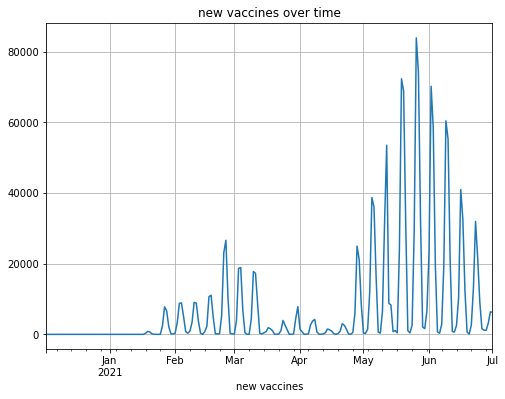

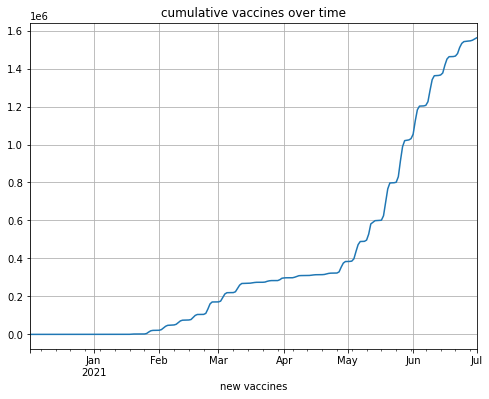

In [10]:

plot_date_based_data(df_in=vaccines_df,
                    new_col_name='nbrpersonsdose2',
                    cum_col_name='cumnbrdose2',
                    str_name='vaccines')
    

### cases by day plots

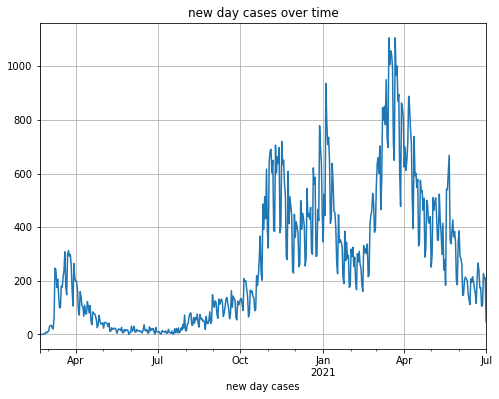

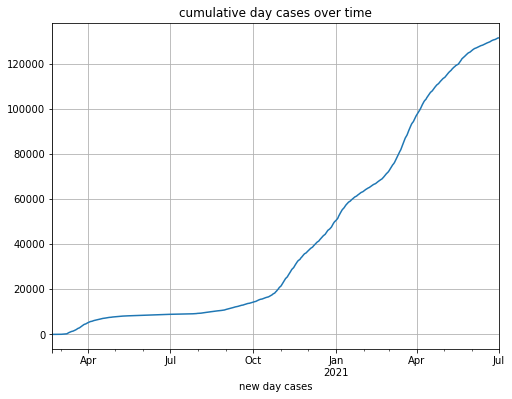

In [11]:

plot_date_based_data(df_in=day_cases_df,
                    new_col_name='new',
                    cum_col_name='cumulative',
                    str_name='day cases')


### hospitalization plots

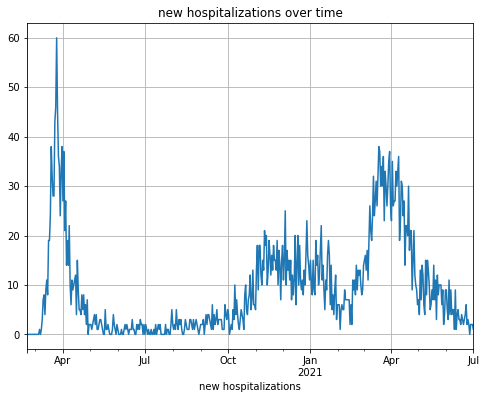

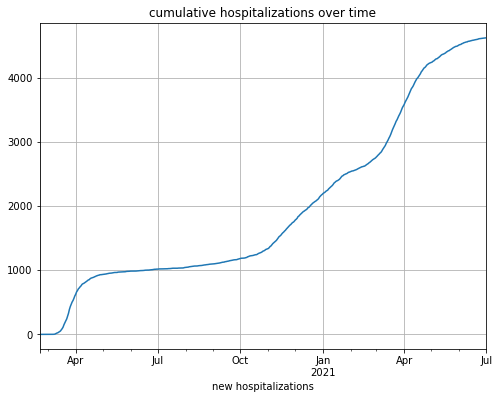

In [12]:

plot_date_based_data(df_in=hospitals_df,
                    new_col_name='new',
                    cum_col_name='cumulative',
                    str_name='hospitalizations')


### aggregate by 7-day rolling average to remove weekly cycles in the data

In [13]:

vaccines_rolling_df = vaccines_df.set_index('date').rolling('7D').mean().reset_index()
day_cases_rolling_df = day_cases_df.set_index('date').rolling('7D').mean().reset_index()
hospitals_rolling_df = hospitals_df.set_index('date').rolling('7D').mean().reset_index()


### view visualizations of each 7 day average dataset

#### vaccines dataset

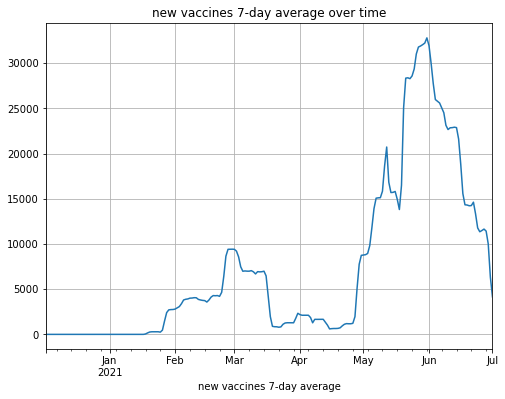

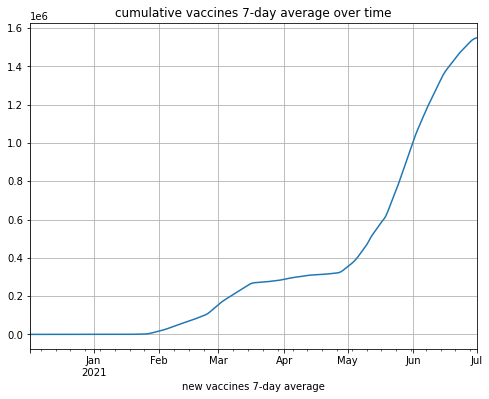

In [14]:

plot_date_based_data(df_in=vaccines_rolling_df,
                    new_col_name='nbrpersonsdose2',
                    cum_col_name='cumnbrdose2',
                    str_name='vaccines 7-day average')


#### cases by day dataset

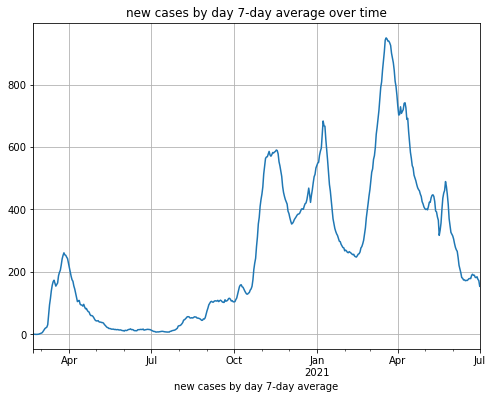

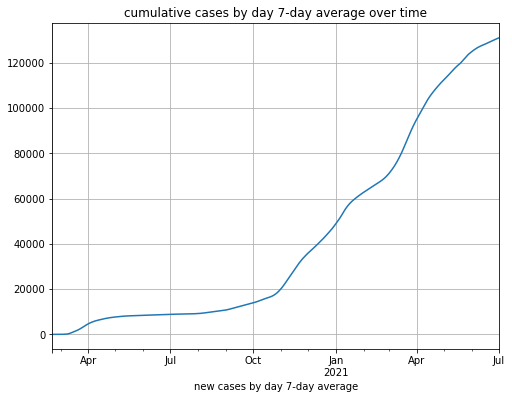

In [15]:

plot_date_based_data(df_in=day_cases_rolling_df,
                    new_col_name='new',
                    cum_col_name='cumulative',
                    str_name='cases by day 7-day average')


#### hospitalizations dataset

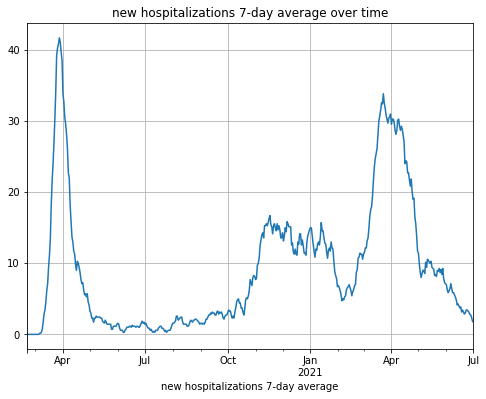

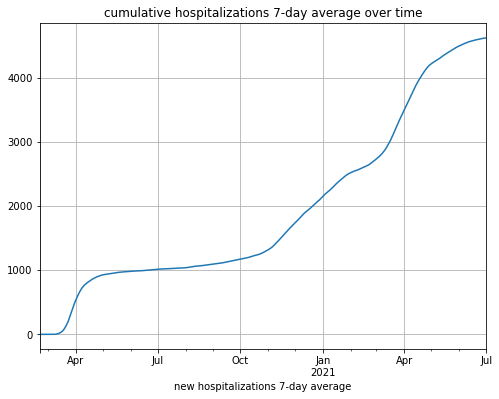

In [16]:

plot_date_based_data(df_in=hospitals_rolling_df,
                    new_col_name='new',
                    cum_col_name='cumulative',
                    str_name='hospitalizations 7-day average')


### adjust vaccine data by 2 weeks to adjust for time after second dose where they are more effective - call this cum_innoculation

In [17]:

vaccines_rolling_df['cum_innoculation'] = vaccines_df.cumnbrdose2.shift(14)


### join vaccine data with cases and hospitalizations by date

In [18]:

joined_df = vaccines_rolling_df.set_index('date').join(
    day_cases_rolling_df.rename({
        'new':'new_cases',
        'cumulative':'cum_cases'}, axis=1).set_index('date'))

joined_df = joined_df.join(
    hospitals_rolling_df.rename({
        'new':'new_hospitalizations',
        'cumulative':'cum_hospitalizations'}, axis=1).set_index('date'))

joined_df.head()


,cumnbrdose1,cumnbrdose2,nbrpersonsdose1,nbrpersonsdose2,cum_innoculation,cum_cases,new_cases,cum_hospitalizations,new_hospitalizations
date,,,,,,,,,
2020-12-02,0.0,0.0,0.0,0.0,NaN,36309.285714,373.857143,1755.714286,13.142857
2020-12-03,0.0,0.0,0.0,0.0,NaN,36672.000000,362.714286,1769.571429,13.857143
2020-12-04,0.0,0.0,0.0,0.0,NaN,37025.428571,353.428571,1784.571429,15.000000
2020-12-05,0.0,0.0,0.0,0.0,NaN,37381.142857,355.714286,1799.000000,14.428571
2020-12-06,0.0,0.0,0.0,0.0,NaN,37741.571429,360.428571,1814.857143,15.857143


### plot rolling 7-day vaccine and new cases data

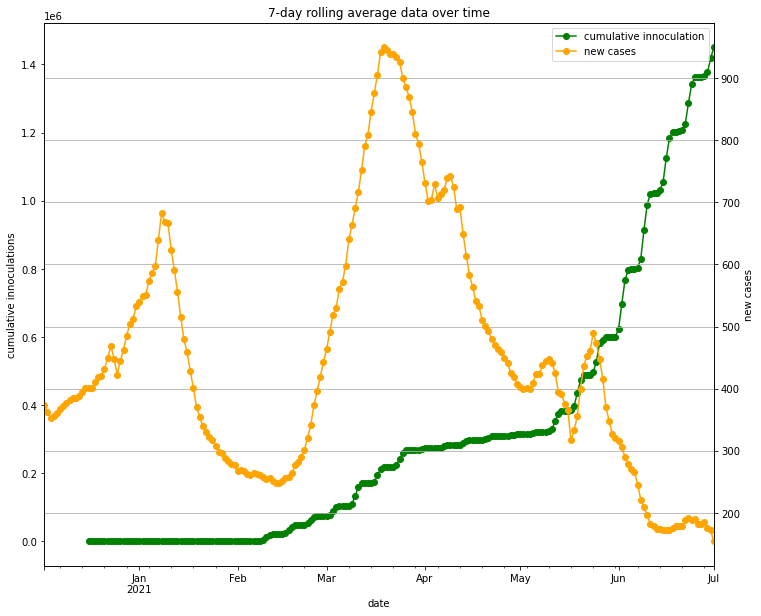

In [19]:

fig, ax1 = plt.subplots(figsize=(12,10))
ax2 = ax1.twinx()

plt.title(f'7-day rolling average data over time')
joined_df.cum_innoculation.plot(marker='o', 
                                ax=ax1, 
                                c='green',
                                label='cumulative innoculation')
joined_df.new_cases.plot(marker='o', 
                         ax=ax2, 
                         c='orange',
                         label='new cases')
plt.xlabel('date')
plt.grid()
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax1.legend(lines, labels, loc=0)
ax1.set_ylabel('cumulative innoculations')
ax2.set_ylabel('new cases')
plt.show()


### plot rolling 7-day vaccine and new hospitalizations data

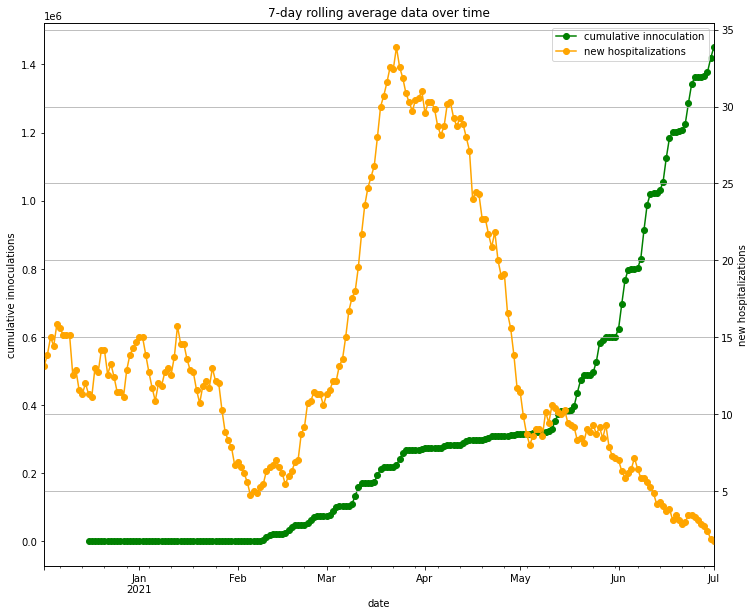

In [20]:

fig, ax1 = plt.subplots(figsize=(12,10))
ax2 = ax1.twinx()

plt.title(f'7-day rolling average data over time')
joined_df.cum_innoculation.plot(marker='o', 
                                ax=ax1, 
                                c='green',
                                label='cumulative innoculation')
joined_df.new_hospitalizations.plot(marker='o', 
                         ax=ax2, 
                         c='orange',
                         label='new hospitalizations')
plt.xlabel('date')
plt.grid()
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax1.legend(lines, labels, loc=0)
ax1.set_ylabel('cumulative innoculations')
ax2.set_ylabel('new hospitalizations')
plt.show()


### limit dataset to only consider from the date where the first innoculated person exists

In [21]:

first_innoc_date = joined_df[joined_df.cum_innoculation > 0].index.min()
analysis_df = joined_df[joined_df.index >= first_innoc_date]
print(f'analysis_df.shape: {analysis_df.shape}')


analysis_df.shape: (152, 9)


### plot rolling 7-day vaccine and new cases data

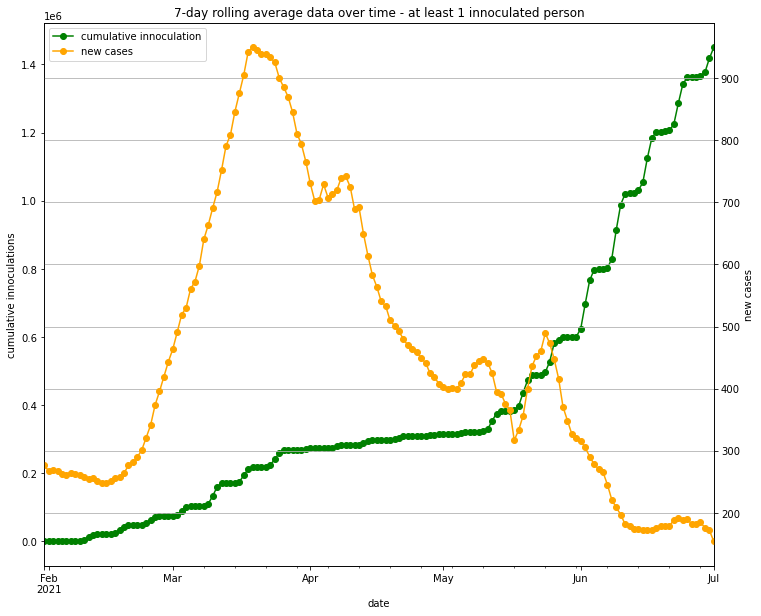

In [22]:

fig, ax1 = plt.subplots(figsize=(12,10))
ax2 = ax1.twinx()

plt.title(f'7-day rolling average data over time - at least 1 innoculated person')
analysis_df.cum_innoculation.plot(marker='o', 
                                ax=ax1, 
                                c='green',
                                label='cumulative innoculation')
analysis_df.new_cases.plot(marker='o', 
                         ax=ax2, 
                         c='orange',
                         label='new cases')
plt.xlabel('date')
plt.grid()
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax1.legend(lines, labels, loc=0)
ax1.set_ylabel('cumulative innoculations')
ax2.set_ylabel('new cases')
plt.show()


### plot rolling 7-day vaccine and new hospitalizations data

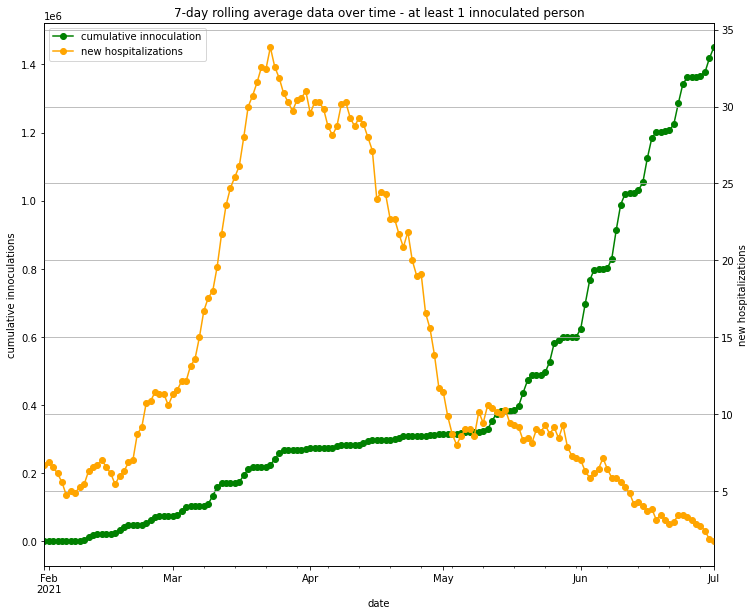

In [23]:

fig, ax1 = plt.subplots(figsize=(12,10))
ax2 = ax1.twinx()

plt.title(f'7-day rolling average data over time - at least 1 innoculated person')
analysis_df.cum_innoculation.plot(marker='o', 
                                ax=ax1, 
                                c='green',
                                label='cumulative innoculation')
analysis_df.new_hospitalizations.plot(marker='o', 
                         ax=ax2, 
                         c='orange',
                         label='new hospitalizations')
plt.xlabel('date')
plt.grid()
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax1.legend(lines, labels, loc=0)
ax1.set_ylabel('cumulative innoculations')
ax2.set_ylabel('new hospitalizations')
plt.show()


### calcualate correlation between cumulative innoculation, new cases and new hospitalizations

In [24]:

corr_df = analysis_df[['cum_innoculation','new_hospitalizations','new_cases']].corr()
corr_df


,cum_innoculation,new_hospitalizations,new_cases
cum_innoculation,1.000000,-0.417865,-0.465836
new_hospitalizations,-0.417865,1.000000,0.937191
new_cases,-0.465836,0.937191,1.000000


### view the pearson correlation and p-values of pearson correlation to build confidence in relationship between cumulative innoculation and new cases/hospitalizations

In [30]:

hospitals_pearson = pearsonr(analysis_df.cum_innoculation, analysis_df.new_hospitalizations)
cases_pearson = pearsonr(analysis_df.cum_innoculation, analysis_df.new_cases)

print('cumulative innoculation and new hospitalization pearson correlation details:')
print(f'\tcorrelation: {np.round(hospitals_pearson[0], 5)}')
print(f'\tcorrelation p-value: {np.round(hospitals_pearson[1], 12)}')
print()
print('cumulative innoculation and new cases pearson correlation details:')
print(f'\tcorrelation: {np.round(cases_pearson[0], 5)}')
print(f'\tcorrelation p-value: {np.round(cases_pearson[1], 12)}')


cumulative innoculation and new hospitalization pearson correlation details:
	correlation: -0.41787
	correlation p-value: 8.4901e-08

cumulative innoculation and new cases pearson correlation details:
	correlation: -0.46584
	correlation p-value: 1.47e-09


### The correlation between cumulative innoculation and new hospitalization is -0.42 and a p-value of this correlation of 8.4901e-08 rejects the null hypothesis that there is no relationship between vaccines and new hospitalizations.
### The correlation between cumulative innoculation and new hospitalization is -0.47 and a p-value of this correlation of 1.47e-09 rejects the null hypothesis that there is no relationship between vaccines and new hospitalizations.

# Due to the rejection of the null hypothesis for both new cases and new hospitalizations not being related to cumulative innoculation, and therefore vaccines, the King of Norway can safely allow vaccinated Americans into Norway.